In [1]:
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from pysme.synthesize import synthesize_spectrum
from astropy.constants import c
from pysme.util import vac2air

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os

warnings.filterwarnings('ignore')

In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [4]:
os.environ['NUMEXPR_MAX_THREADS'] = '80' #change this number using the correct number of cores/threads in jupyter.slurm

In [5]:
#Prepare catalogue ingestion

In [6]:
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits_all_elems.csv')

In [7]:
uves.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,zrfe,life,alfe,kfe,ofe,mofe,cefe,thfe,prfe,gdfe
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,0.009995,-2.665628,-0.833245,-2.665628,-2.265628,-2.665628,-2.665628,-2.665628,-2.665628,-2.665628
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,0.651458,-3.166961,-0.832848,-3.166961,-2.766961,-3.166961,-3.166961,-3.166961,-3.166961,-3.166961


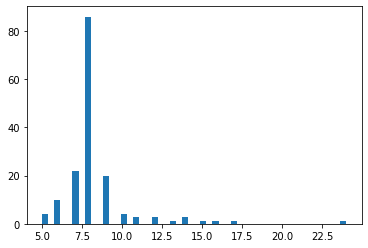

In [8]:
plt.hist(uves.niter_eu.values, bins=50)
plt.show()

In [9]:
#pysme that only need to be executed once
# linelist_short_all = ValdFile('linelist/3800-6800_short.lin')
# linelist_short_all = ValdFile('linelist/linelist_Li.lin')
linelist_short_all = ValdFile('linelist/VALD_korg_linelist_3000_9000.lin', medium='air')
linelist_short_all.wlcent = vac2air(linelist_short_all.wlcent, 'A')

#Lithium only
# linelist_short_all = linelist_short_all[pd.DataFrame(linelist_short_all).query("species == 'Li 1'").index]

# linelist_short_all = linelist_short_all[linelist_short_all.depth > 0.05]
print('Number of lines in the linelist: %d' %linelist_short_all.species.size)

delta_H_line = 10. #AA
delta_line = 1.0 #AA
wl_G_band = 4300 #AA
delta_G_band = 40. #AA

wl_Halpha_line = 6562.79 #AA
delta_Halpha = 1.0 #AA
wl_Hbeta_line = 4861.35 #AA
delta_Hbeta = 0.75 #AA

[2024-06-20 10:55:09,910] [INFO] [vald:loads:173]: Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


INFO - Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


[2024-06-20 10:55:10,807] [WARNING] [vald:parse_references:530]: Could not find citation key: FBHM
[2024-06-20 10:55:10,808] [DEBUG] [vald:parse_references:531]: 'fbhm'


WARNING - Could not find citation key: FBHM
Number of lines in the linelist: 41861


In [10]:
# linelist_short_all.add(species='Li 1', wlcent=6103.540, excit=1.8480, gflog=0.072, gamrad=8.020, gamqst=-4.660, gamvw=0.0)
# linelist_short_all = linelist_short_all.sort()

In [11]:
# from pysme.linelist.linelist import LineList

In [12]:
# from io import StringIO

# data_string = r"""species,wlcent,excit,vmic,gflog,gamrad,gamqst,gamvw,lande,depth,reference,atom_number,ionization
# #Li 1,6103.540,1.8480, 1.0, 0.072,8.020,-4.660,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# #Li 1,6103.574,1.8480, 1.0,-1.014,8.020,-4.660,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# #Li 1,6103.651,1.8480, 1.0, 0.327,8.020,-4.660,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# #Li 1,6103.664,1.8480, 1.0,-0.627,8.020,-4.660,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# #Li 1,6103.686,1.8480, 1.0,-0.758,8.020,-4.660,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# #Li 1,6103.699,1.8480, 1.0,-1.713,8.020,-4.660,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# Li 1,6707.764,0.0000, 1.0,-0.036,7.560,-5.780,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# Li 1,6707.914,0.0000, 1.0,-0.337,7.560,-5.780,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0
# Li 1,6707.922,0.0000, 1.0,-1.122,7.560,-5.780,99.000,0.011,'  62 iso:REB  62 YD  62 gf:YD  62 YD  62 YD  62 YD  62 YD (7)Li         ',1.0,1.0,1.0"""

# data_io = StringIO(data_string)
# ll = pd.read_csv(data_io, comment='#')

In [13]:
# ll.head(2)

In [14]:
# linelist_short_all = LineList(linedata=ll, medium='air')

In [15]:
wmin_blue = 4000 #AA
wmax_blue = 4500 #AA
wmin_red1 = 4730 #AA
wmax_red1 = 5700 #AA
wmin_red2 = 5850 #AA
wmax_red2 = 6800 #AA

In [16]:
linelist_short_all = linelist_short_all[((linelist_short_all.wlcent > wmin_blue) & (linelist_short_all.wlcent < wmax_blue)) | \
                                         (linelist_short_all.wlcent > wmin_red1) & (linelist_short_all.wlcent < wmax_red1) | \
                                         (linelist_short_all.wlcent > wmin_red2) & (linelist_short_all.wlcent < wmax_red2)]

In [17]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [18]:
# elems_to_include = ['H', 'Fe', 'Mg', 'Ti', 'Ca', 'Na'] #['Fe', 'Mg', 'Ti', 'Ca', 'Na', 'Si', 'Mn', 'Ni', 'Zr'] #['Fe', 'Mg', 'Ti', 'Ca', 'Na']
# lines_min_depth = 0.00
# lines_max_depth = 1.00
# linelist_short_temp = linelist_short_all[(linelist_short_all.depth > lines_min_depth) & (linelist_short_all.depth < lines_max_depth)]
linelist_short_temp = linelist_short_all
# elems_to_include = ['H 1', 'Fe 1', 'Fe 2', 'Mg 1', 'Ti 1', 'Ti 2', 'Ca 1', 'Na 1'] #['H 1', 'Fe 1', 'Fe 2', 'Mg 1', 'Ti 1', 'Ti 2', 'Ca 1', 'Na 1', 'Si 1', 'Si 2', 'Mn 1', 'Mn 2', 'Ni 1', 'Zr 2']  #['Fe 1', 'Fe 2', 'Mg 1', 'Ti 1', 'Ti 2', 'Ca 1', 'Na 1']
# f_linelist = np.asarray([True if elem in elems_to_include else False for elem in linelist_short_temp.species])
# linelist = linelist_short_temp[f_linelist]

In [19]:
#Check if the linelist contains all the elements !!

In [20]:
print(np.unique(linelist_short_temp.species))

ll = pd.DataFrame(linelist_short_temp)
print(ll.query("species == 'Eu 2'").species.size)

['Al 1' 'Ba 1' 'Ba 2' 'C 1' 'C2 1' 'CH 1' 'CN 1' 'Ca 1' 'Ca 2' 'Cd 1'
 'Ce 2' 'Co 1' 'Co 2' 'Cr 1' 'Cr 2' 'Cu 1' 'Dy 1' 'Dy 2' 'Er 1' 'Er 2'
 'Eu 2' 'Fe 1' 'Fe 2' 'Ga 1' 'Gd 2' 'Ge 1' 'H 1' 'Hf 2' 'Ho 2' 'In 1'
 'K 1' 'La 2' 'Li 1' 'Lu 2' 'Mg 1' 'Mg 2' 'Mn 1' 'Mn 2' 'Mo 1' 'Mo 2'
 'Na 1' 'Nb 1' 'Nb 2' 'Nd 2' 'Ni 1' 'Ni 2' 'O 1' 'Os 1' 'Pb 1' 'Pd 1'
 'Pr 2' 'Pt 1' 'Rh 1' 'Ru 1' 'S 1' 'Sc 1' 'Sc 2' 'Si 1' 'Si 2' 'Sm 2'
 'Sr 1' 'Sr 2' 'Tb 2' 'Th 2' 'Ti 1' 'Ti 2' 'Tl 1' 'Tm 2' 'U 2' 'V 1' 'V 2'
 'W 1' 'Y 1' 'Y 2' 'Zn 1' 'Zr 1' 'Zr 2']
10


In [21]:
ll.query("species == 'Eu 2'").sort_values(by='excit', ascending=True).head(4)#.sort_values(by='depth', ascending=False)

,species,wlcent,excit,vmic,gflog,gamrad,gamqst,gamvw,lande,depth,reference,atom_number,ionization
2055,Eu 2,4129.694041,0.0,1.0,-0.100,0.0,0.0,0.0,1.93,0.621,15 iso:LWHS 15 LWHS 15 gf:LWHS 15 LWHS 1...,1.0,2.0
2056,Eu 2,4129.720035,0.0,1.0,-0.062,0.0,0.0,0.0,1.93,0.639,15 iso:LWHS 15 LWHS 15 gf:LWHS 15 LWHS 1...,1.0,2.0
3461,Eu 2,4205.027982,0.0,1.0,-0.110,0.0,0.0,0.0,1.67,0.609,15 iso:LWHS 15 LWHS 15 gf:LWHS 15 LWHS 1...,1.0,2.0
3463,Eu 2,4205.053975,0.0,1.0,-0.072,0.0,0.0,0.0,1.67,0.627,15 iso:LWHS 15 LWHS 15 gf:LWHS 15 LWHS 1...,1.0,2.0


In [22]:
i = 0
limit_elem = [0]

In [23]:
def limits(species = '', species_to_keep = [], spec_id = '', sme_file = '', wlmin = 0, wlmax = 0, start = -2.0, stop = 1.0, step = 0.25, limit_elem=limit_elem, i=i):
    
    if i > 5:
        return
    print(i)
    
    # plt.figure(figsize=(7,7), dpi=100)
    
    util.start_logging('logs/elems_limits.dat', level='WARNING')
    species = species
    limit = solar.abund.get_element('%s' %species)
    # start, stop, step = -2.0, 2.0, 0.25

    for delta_abund in np.linspace(start, stop, int((stop - start) / step + 1)):

        synth = SME_Structure.load(sme_file)
        # if delta_abund == start: print(synth.abund.get_element('C'))
        # if delta_abund == start: plt.step(synth.wave.data, synth.synth.data, lw=1, color='r')
        synth.linelist = linelist_short_all[(linelist_short_all.wlcent > wlmin) & (linelist_short_all.wlcent < wlmax)]

        f_wl_limit = (synth.wave.data > wlmin) & (synth.wave.data < wlmax)

        for elem in synth.abund.pattern.keys():
            if (elem == 'H') or (elem == 'He'):
                continue
            if elem in species_to_keep:
                continue
            synth.abund.update_pattern({elem:0.0})
        synth.abund.update_pattern({'%s' %species: solar.abund.get_element('%s' %species) + delta_abund})
        # print('%s' %species, solar.abund.get_element('%s' %species) + delta_abund)

        synth.vrad_flag = 'None'
        synth.cscale_flag = 'None'
        synth = synthesize_spectrum(synth)
        # synth_data = synth.synth.data

        mean_synth = np.percentile(synth.synth.data[f_wl_limit], 10)
        std_spec = np.std(synth.spec.data[f_wl_limit])
        
        # if delta_abund == start: plt.step(synth.wave.data, synth.spec.data, lw=1, color='k')
        # if delta_abund == start: plt.hlines(1.-std_spec, wlmin, wlmax, color='b', lw=1, ls='--')
        # plt.step(synth.wave.data, synth.synth.data, lw=1, color='g', alpha=0.2, where='mid')
        # plt.hlines(mean_synth, wlmin, wlmax, color='r', lw=1, ls='--', alpha=0.3)
        # plt.xlim(wlmin, wlmax)
        # plt.ylim(0.9, 1.1)

        #If mean synth flux is more (bigger depth) that std: you are in outside limit regime
        #linspace in the starst is fliped to ascend in abundance space
        if mean_synth < (1. - std_spec):
            # print(delta_abund, step/2)
            limit = solar.abund.get_element('%s' %species) + delta_abund - step/2.
            # plt.show()
            pd.DataFrame(data=np.vstack((spec_id, limit)).T, columns=['spec_id', 'limit']).to_csv('tmp_merged/limits.csv', mode='a', header=False, index=False)
            return
        else:
            continue
    # plt.show()
    pd.DataFrame(data=np.vstack((spec_id, limit)).T, columns=['spec_id', 'limit']).to_csv('tmp_merged/limits.csv', mode='a', header=False, index=False)
    return 

In [62]:
#Eu

In [24]:
is_limit_elem = np.zeros_like(uves.ra.values).astype(bool)
elem = 'Eu'
limit_elem = uves['%s' %elem.lower()].values

f_is_limit = ((uves['e%s_sme' %elem.lower()].values > 0.15) & (uves['%s' %elem.lower()].values < 1.0)) | (uves['e%s_sme' %elem.lower()].values/uves['%s' %elem.lower()].values > 0.7)
is_limit_elem[f_is_limit] = True

In [25]:
limit_elem[f_is_limit]

array([ 0.92345969,  0.87329759, -0.17290515,  0.82552624,  0.88120299,
        0.78048003,  0.24037241,  0.93707561,  0.19241659,  0.94855477,
        0.8320559 ,  0.46822537,  0.57454918,  0.87676192,  0.46390538,
        0.84395309,  0.6473916 ,  0.46673812,  0.23887947,  0.2973824 ,
        0.85247528,  0.85732094,  0.97236545,  0.43563308,  0.81121311,
        0.36887358,  0.26664521,  0.78048668,  0.43962619,  0.10914014,
        0.6013318 , -0.26873871,  0.61106582,  0.82994645,  0.66470164,
        0.93460308, -0.04652269,  0.64984013,  0.97641766,  0.87427929,
        0.95433633,  0.74472237,  0.53620738,  0.48007569,  0.88296483,
        0.34167506,  0.63289998,  0.57522742,  0.77076239,  0.47093317,
        0.32888538,  1.13835143,  0.67571992,  0.771711  ,  0.80208341,
        0.94020678,  0.58134695,  0.77164588,  0.95113281,  0.40597368,
        0.78211027,  0.83256727, -0.53230904,  0.73392381, -0.0666755 ,
        0.85996043,  0.3718069 ,  0.23068616,  0.66061807,  0.50

In [94]:
eu_wl_limits = [4129, 4130.5]

In [29]:
Parallel(n_jobs=-1, verbose=5)(delayed(limits)(species = '%s' %elem, species_to_keep = [], spec_id = '%s' %uves.spec_id.values[i], 
                                               sme_file = 'sme_save/elem_%s_%s.sme' %(elem.lower(), uves.spec_id.values[i]), wlmin = eu_wl_limits[0], wlmax = eu_wl_limits[1], 
                                               start = -1.0, stop = 1.0, step = 0.1) for i, input_row in uves.reset_index(inplace=False, drop=True).iloc[f_is_limit].iterrows())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  82 | elapsed:  4.6min remaining: 42.4min
[Parallel(n_jobs=-1)]: Done  25 out of  82 | elapsed:  6.4min remaining: 14.7min
[Parallel(n_jobs=-1)]: Done  42 out of  82 | elapsed:  7.6min remaining:  7.3min


0
0
0
0


[Parallel(n_jobs=-1)]: Done  59 out of  82 | elapsed:  9.1min remaining:  3.6min


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


[Parallel(n_jobs=-1)]: Done  76 out of  82 | elapsed: 13.2min remaining:  1.0min


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed: 17.3min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

0
0
0
0
0
0
0
0
0
0


In [30]:
limits_eu = pd.read_csv('tmp_merged/limits.csv', names=['spec_id', 'limit'])

In [48]:
limit_elem[f_is_limit] = uves.iloc[f_is_limit].merge(right=limits_eu, right_on='spec_id', left_on='spec_id').limit.values

In [51]:
uves['is_limit_%s' %elem.lower()] = is_limit_elem
uves['limit_%s' %elem.lower()] = limit_elem

In [53]:
uves.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits_all_elems_lims_eu.csv', header=True, index=False)

In [25]:
#Ba

In [64]:
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits_all_elems_lims_eu.csv')

In [65]:
is_limit_elem = np.zeros_like(uves.ra.values).astype(bool)
elem = 'Ba'
limit_elem = uves.ba_nlte.values

f_is_limit = uves['e%s_sme' %elem.lower()].values > 0.80
is_limit_elem[f_is_limit] = True

In [66]:
limit_elem[is_limit_elem]

array([0.42697944, 0.41575184, 0.85533906])

In [67]:
ba_wl_limits = [4933.6, 4934.6]

In [48]:
Parallel(n_jobs=-1, verbose=5)(delayed(limits)(species = '%s' %elem, species_to_keep = [], spec_id = '%s' %uves.spec_id.values[i], 
                                               sme_file = 'sme_save/elem_%s_%s.sme' %(elem.lower(), uves.spec_id.values[i]), wlmin = ba_wl_limits[0], wlmax = ba_wl_limits[1], 
                                               start = -2.0, stop = 1.0, step = 0.1) for i, input_row in uves.reset_index(inplace=False, drop=True).iloc[f_is_limit].iterrows())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s


KeyboardInterrupt: 

In [68]:
limits_ba = pd.read_csv('tmp_merged/limits.csv', names=['spec_id', 'limit'])

In [69]:
limit_elem[f_is_limit] = uves.iloc[f_is_limit].merge(right=limits_ba, right_on='spec_id', left_on='spec_id').limit.values

In [70]:
uves['is_limit_%s' %elem.lower()] = is_limit_elem
uves['limit_%s' %elem.lower()] = limit_elem

In [72]:
uves.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits_all_elems_lims_euba.csv', header=True, index=False)

In [80]:
uves.query('sr < 0.5').spec_id

19    2882976353396129408_3708481_137
20    2882976353396129408_3708481_142
Name: spec_id, dtype: object

In [225]:
#Final values for limit decision:
#eBa > 0.7 (3 stars)
#(eEu_sme > 0.15 & Eu < 1.0) | (eEu_sme/Eu > 0.7)

In [92]:
sme = SME_Structure.load('sme_save/elem_sr_2882976353396129408_3708481_137.sme')

[2024-06-20 11:12:12,881] [INFO] [sme:load:839]: Loading SME file sme_save/elem_sr_2882976353396129408_3708481_137.sme


INFO - Loading SME file sme_save/elem_sr_2882976353396129408_3708481_137.sme


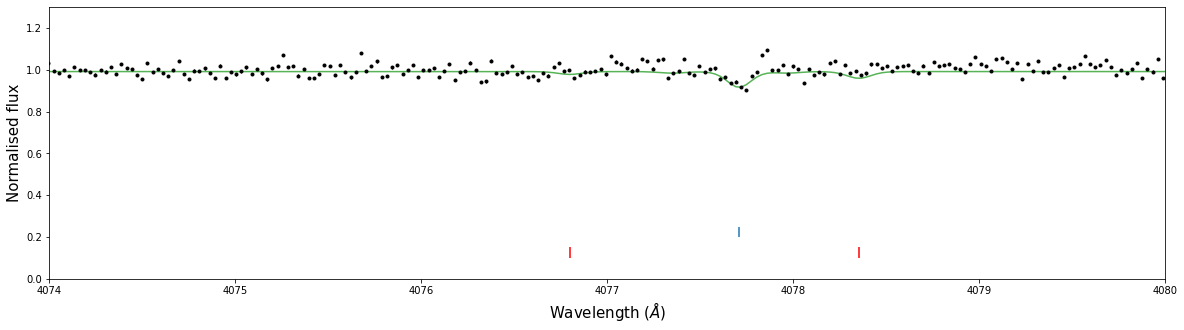

In [94]:
plt.figure(figsize=(20,5))

elems_to_include = ['Sr 2']

# plt.step(sme.wave.data, sme.spec.data, lw=0.8, color='k', where='mid')
plt.errorbar(sme.wave.data, sme.spec.data, fmt='k.', lw=1, yerr=sme.uncs.data)

#Al only
# x = sme.wave.data
# plt.plot(sme.wave.data, sme.spec.data/(sme.cscale[0][0]*(x-x[0])**2. + sme.cscale[0][1]*(x-x[0]) + sme.cscale[0][2]), lw=0.8, color='k')
# plt.plot(sme.wave.data, sme.synth.data/(sme.cscale[0][0]*(x-x[0])**2. + sme.cscale[0][1]*(x-x[0]) + sme.cscale[0][2]), lw=1.5, color='C2', alpha=0.8)

# synth_smooth = uniform_filter1d(sme.synth.data, size=50)
# plt.plot(sme.wave.data, synth_smooth, lw=1.5, color='C2', alpha=0.8)
plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='C2', alpha=0.8)

# plt.scatter(sme.wave.data, sme.mask.data, color='grey', alpha=0.2)
# plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2] - 1, color='grey', alpha=0.2)

for wline, species in pd.DataFrame(sme.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if species not in elems_to_include:
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    plt.vlines(wline, 0.2, 0.25, color='C0')
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)

# plt.vlines(5167.3, 0, 1, )

# plt.xlim(4400, 4500) #all
# plt.xlim(4090, 4100) #Fe

# plt.xlim(4930, 4938) #Ba
# plt.xlim(5851, 5857) #Ba
# plt.xlim(6139, 6145) #Ba
# plt.xlim(6492, 6502) #Ba

plt.xlim(4213, 4219) #Sr
plt.xlim(4074, 4080) #Sr

# plt.xlim(4128, 4132) #Eu
# plt.xlim(4200, 4210) #Eu

# plt.xlim(4390, 4402) #Ti
# plt.xlim(4430, 4470) #Ti
# plt.xlim(4980, 5020) #Ti

# plt.xlim(5474, 5480) #Ni
# plt.xlim(5077, 5083) #Ni
# plt.xlim(4398, 4404) #Ni

# plt.xlim(5165.5, 5185) #Mg

# plt.xlim(4222, 4232) #Ca
# plt.xlim(4433, 4458) #Ca
# plt.xlim(6438, 6463) #Ca

# plt.xlim(4175, 4180) #Y
# plt.xlim(4200, 4210) #Y
# plt.xlim(4230, 4240) #Y
# plt.xlim(4372, 4378) #Y
# plt.xlim(4880, 4905) #Y
# plt.xlim(5200, 5210) #Y
# plt.xlim(5084, 5091) #Y

# plt.xlim(4025, 4038) #La
# plt.xlim(4070, 4090) #La
# plt.xlim(4120, 4130) #La

# plt.xlim(4028, 4039) #Mn
# plt.xlim(4125, 4131) #Mn

# plt.xlim(5880, 5900) #Na

# plt.xlim(4085, 4100) #Co
# plt.xlim(4115, 4125) #Co

# plt.xlim(4235, 4260) #Cr
# plt.xlim(4343, 4355) #Cr
# plt.xlim(5200, 5215) #Cr
# plt.xlim(5342, 5354) #Cr

# plt.xlim(4000, 4005) #Dy
# plt.xlim(4070, 4080) #Dy
# plt.xlim(4126, 4132) #Dy
# plt.xlim(4954, 4960) #Dy
# plt.xlim(4100, 4106) #Dy
# plt.xlim(4072, 4079) #Dy

# plt.xlim(4010, 4015) #Nd
# plt.xlim(4105, 4114) #Nd
# plt.xlim(4155, 4158) #Nd
# plt.xlim(4176, 4180) #Nd
# plt.xlim(4245, 4255) #Nd

# plt.xlim(4010, 4020) #Sc
# plt.xlim(4235, 4260) #Sc
# plt.xlim(4370, 4420) #Sc
# plt.xlim(4395, 4405) #Sc
# plt.xlim(5025, 5040) #Sc
# plt.xlim(5235, 5245) #Sc
# plt.xlim(5525, 5532) #Sc

# plt.xlim(4100, 4106) #Si
# plt.xlim(4790, 4794) #Si
# plt.xlim(6345, 6349) #Si

# plt.xlim(4000, 4010) #V
# plt.xlim(4020, 4025) #V
# plt.xlim(4030, 4038) #V
# plt.xlim(4108, 4118) #V
# plt.xlim(4375, 4393) #V

# plt.xlim(4808, 4814) #Zn
# plt.xlim(6360, 6364) #Zn

# plt.xlim(4025, 4035) #Zr
# plt.xlim(4045, 4050) #Zr
# plt.xlim(4145, 4165) #Zr
# plt.xlim(4154, 4163) #Zr
# plt.xlim(4205, 4220) #Zr

# plt.xlim(6694, 6700) #Al
# plt.xlim(5555, 5559) #Al
# plt.xlim(6782, 6786) #Al
# plt.xlim(4874, 4878) #Al
# plt.xlim(3898, 3902) #Al
# plt.xlim(3959, 3963) #Al
# plt.xlim(3940, 3965) #Al

# plt.xlim(6702, 6715) #Li
# plt.xlim(6100, 6105) #Li

# plt.xlim(4365, 4371) #O
# plt.xlim(6150, 6160) #O
# plt.xlim(6298, 6302) #[O]
# plt.xlim(6360, 6366) #O

# plt.xlim(4040, 4050) #K

plt.ylim(0, 1.3)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)
# plt.xlim(6500, 6600)
# plt.savefig('plots/CEMP.pdf')
plt.show()

In [88]:
sme.fitresults.iterations

4

In [89]:
sme.monh

-2.5161154658435696

In [90]:
sme.fitresults.values, sme.fitresults.uncertainties, sme.fitresults.fit_uncertainties, sme.monh, sme.vmac

(array([0.43863759]),
 array([0.27925439]),
 [0.07291929963215027],
 -2.5161154658435696,
 6.18664989343837)

In [91]:
sme.fitresults.iterations

4

In [158]:
sme.cscale

array([[0.98948319],
       [0.99359499],
       [0.99472645]])

In [159]:
sme.vrad

array([0.14304188, 0.0247288 , 1.60177047])

In [160]:
sme.linelist

   species      wlcent  gflog   excit  j_lo   e_upp  j_up  lande_lower  \
0     Fe 2  4128.73910 -3.578  2.5827   2.5  5.5848   1.5         1.58   
1     Ti 2  4129.15094 -1.770  1.8927   3.5  4.8945   2.5         0.89   
2     Eu 2  4129.67754 -1.794  0.0000   4.0  3.0014   4.0         1.98   
3     Eu 2  4129.68030 -1.317  0.0000   4.0  3.0014   4.0         1.98   
4     Eu 2  4129.68396 -1.598  0.0000   4.0  3.0014   4.0         1.98   
5     Eu 2  4129.68728 -1.259  0.0000   4.0  3.0014   4.0         1.98   
6     Eu 2  4129.69004 -1.794  0.0000   4.0  3.0014   4.0         1.98   
7     Eu 2  4129.69428 -1.539  0.0000   4.0  3.0014   4.0         1.98   
8     Eu 2  4129.69760 -1.129  0.0000   4.0  3.0014   4.0         1.98   
9     Eu 2  4129.70092 -1.598  0.0000   4.0  3.0014   4.0         1.98   
10    Eu 2  4129.70920 -1.576  0.0000   4.0  3.0014   4.0         1.98   
11    Eu 2  4129.71182 -0.978  0.0000   4.0  3.0014   4.0         1.98   
12    Eu 2  4129.71513 -1.539  0.0000 

In [221]:
uves_fe.sort_values(by='monh', ascending=True).spec_id

7      2541284393302759296_3708442_129
62     4854289415101796608_3708430_135
103    6488378098744387968_3576337_082
70     5735381717990313216_3572855_004
38     3572437218517370240_3573679_095
                    ...               
35     3543785319887452800_3572787_023
133    6728409939582968192_3572831_014
110    6631364397619544448_3572790_006
64     4905666294932720000_3708505_125
41     3608416056475856512_3708499_157
Name: spec_id, Length: 160, dtype: object

In [ ]:
#Small analysis of the elems mcmc

In [15]:
%%time
#Merge all files into one

# os.system('cat tmp_elems/elem_fe_???????????????????_???????_???.csv > tmp_merged/elem_fe_merged.csv');
# os.system('cat tmp_elems/elem_fe_nlte*.csv > tmp_merged/elem_fe_nlte_merged.csv');
os.system('cat tmp_elems/elem_ba_???????????????????_???????_???.csv > tmp_merged/elem_ba_merged.csv');
os.system('cat tmp_elems/elem_ba_nlte*.csv > tmp_merged/elem_ba_nlte_merged.csv');
os.system('cat tmp_elems/elem_sr*.csv > tmp_merged/elem_sr_merged.csv');
os.system('cat tmp_elems/elem_eu*.csv > tmp_merged/elem_eu_merged.csv');
# os.system('cat tmp_elems/elem_ti_???????????????????_???????_???.csv > tmp_merged/elem_ti_merged.csv');
# os.system('cat tmp_elems/elem_ti_nlte*.csv > tmp_merged/elem_ti_nlte_merged.csv');
# os.system('cat tmp_elems/elem_ni*.csv > tmp_merged/elem_ni_merged.csv');
# os.system('cat tmp_elems/elem_mg_???????????????????_???????_???.csv > tmp_merged/elem_mg_merged.csv');
# os.system('cat tmp_elems/elem_mg_nlte*.csv > tmp_merged/elem_mg_nlte_merged.csv');
# os.system('cat tmp_elems/elem_ca_???????????????????_???????_???.csv > tmp_merged/elem_ca_merged.csv');
# os.system('cat tmp_elems/elem_ca_nlte*.csv > tmp_merged/elem_ca_nlte_merged.csv');
# os.system('cat tmp_elems/elem_y*.csv  > tmp_merged/elem_y_merged.csv');
# os.system('cat tmp_elems/elem_la*.csv > tmp_merged/elem_la_merged.csv');
# os.system('cat tmp_elems/elem_mn*.csv > tmp_merged/elem_mn_merged.csv');
# os.system('cat tmp_elems/elem_na*.csv > tmp_merged/elem_na_merged.csv');
# os.system('cat tmp_elems/elem_co*.csv > tmp_merged/elem_co_merged.csv');
# os.system('cat tmp_elems/elem_cr*.csv > tmp_merged/elem_cr_merged.csv');
# os.system('cat tmp_elems/elem_dy*.csv > tmp_merged/elem_dy_merged.csv');
# os.system('cat tmp_elems/elem_nd*.csv > tmp_merged/elem_nd_merged.csv');
# os.system('cat tmp_elems/elem_sc*.csv > tmp_merged/elem_sc_merged.csv');
# os.system('cat tmp_elems/elem_si_???????????????????_???????_???.csv > tmp_merged/elem_si_merged.csv');
# os.system('cat tmp_elems/elem_si_nlte*.csv > tmp_merged/elem_si_nlte_merged.csv');
# os.system('cat tmp_elems/elem_v*.csv  > tmp_merged/elem_v_merged.csv');
# os.system('cat tmp_elems/elem_zn*.csv > tmp_merged/elem_zn_merged.csv');
# os.system('cat tmp_elems/elem_zr*.csv > tmp_merged/elem_zr_merged.csv');
# os.system('cat tmp_elems/elem_li*.csv > tmp_merged/elem_li_merged.csv');
# os.system('cat tmp_elems/elem_al*.csv > tmp_merged/elem_al_merged.csv');
# os.system('cat tmp_elems/elem_k*.csv > tmp_merged/elem_k_merged.csv');
# os.system('cat tmp_elems/elem_o*.csv > tmp_merged/elem_o_merged.csv');
# os.system('cat tmp_elems/elem_mo*.csv > tmp_merged/elem_mo_merged.csv');
# os.system('cat tmp_elems/elem_ce*.csv > tmp_merged/elem_ce_merged.csv');
# os.system('cat tmp_elems/elem_u*.csv > tmp_merged/elem_u_merged.csv');
# os.system('cat tmp_elems/elem_th*.csv > tmp_merged/elem_th_merged.csv');
# os.system('cat tmp_elems/elem_pr*.csv > tmp_merged/elem_pr_merged.csv');
# os.system('cat tmp_elems/elem_gd*.csv > tmp_merged/elem_gd_merged.csv');

# os.system("sed '1i spec_id,fe,efe_sme,efe_fit,sme_vrad1,sme_vrad2,sme_vrad3,vmac' tmp_merged/elem_fe_merged.csv -i ");
# os.system("sed '1i spec_id,fe_nlte,efe_nlte_sme,efe_nlte_fit,sme_vrad1,sme_vrad2,sme_vrad3,vmac' tmp_merged/elem_fe_nlte_merged.csv -i ");
os.system("sed '1i spec_id,ba,eba_sme,eba_fit,niter_ba' tmp_merged/elem_ba_merged.csv -i ");
os.system("sed '1i spec_id,ba_nlte,eba_nlte_sme,eba_nlte_fit,niter_ba_nlte' tmp_merged/elem_ba_nlte_merged.csv -i ");
os.system("sed '1i spec_id,sr,esr_sme,esr_fit,niter_sr' tmp_merged/elem_sr_merged.csv -i ");
os.system("sed '1i spec_id,eu,eeu_sme,eeu_fit,niter_eu' tmp_merged/elem_eu_merged.csv -i ");
# os.system("sed '1i spec_id,ti,eti_sme,eti_fit,niter_ti' tmp_merged/elem_ti_merged.csv -i ");
# os.system("sed '1i spec_id,ti_nlte,eti_nlte_sme,eti_nlte_fit,niter_ti_nlte' tmp_merged/elem_ti_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,ni,eni_sme,eni_fit' tmp_merged/elem_ni_merged.csv -i ");
# os.system("sed '1i spec_id,mg,emg_sme,emg_fit,niter_mg' tmp_merged/elem_mg_merged.csv -i ");
# os.system("sed '1i spec_id,mg_nlte,emg_nlte_sme,emg_nlte_fit,niter_mg_nlte' tmp_merged/elem_mg_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,ca,eca_sme,eca_fit,niter_ca' tmp_merged/elem_ca_merged.csv -i ");
# os.system("sed '1i spec_id,ca_nlte,eca_nlte_sme,eca_nlte_fit,niter_ca_nlte' tmp_merged/elem_ca_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,y,ey_sme,ey_fit,niter_y' tmp_merged/elem_y_merged.csv -i ");
# os.system("sed '1i spec_id,la,ela_sme,ela_fit,niter_la' tmp_merged/elem_la_merged.csv -i ");
# os.system("sed '1i spec_id,mn,emn_sme,emn_fit' tmp_merged/elem_mn_merged.csv -i ");
# os.system("sed '1i spec_id,na,ena_sme,ena_fit' tmp_merged/elem_na_merged.csv -i ");
# os.system("sed '1i spec_id,co,eco_sme,eco_fit' tmp_merged/elem_co_merged.csv -i ");
# os.system("sed '1i spec_id,cr,ecr_sme,ecr_fit' tmp_merged/elem_cr_merged.csv -i ");
# os.system("sed '1i spec_id,dy,edy_sme,edy_fit,niter_dy' tmp_merged/elem_dy_merged.csv -i ");
# os.system("sed '1i spec_id,nd,end_sme,end_fit,niter_nd' tmp_merged/elem_nd_merged.csv -i ");
# os.system("sed '1i spec_id,sc,esc_sme,esc_fit' tmp_merged/elem_sc_merged.csv -i ");
# os.system("sed '1i spec_id,si_nlte,esi_nlte_sme,esi_nlte_fit,niter_si_nlte' tmp_merged/elem_si_nlte_merged.csv -i ");
# os.system("sed '1i spec_id,si,esi_sme,esi_fit,niter_si' tmp_merged/elem_si_merged.csv -i ");
# os.system("sed '1i spec_id,v,ev_sme,ev_fit' tmp_merged/elem_v_merged.csv -i ");
# os.system("sed '1i spec_id,zn,ezn_sme,ezn_fit' tmp_merged/elem_zn_merged.csv -i ");
# os.system("sed '1i spec_id,zr,ezr_sme,ezr_fit' tmp_merged/elem_zr_merged.csv -i ");
# os.system("sed '1i spec_id,li,eli_sme,eli_fit,niter_li' tmp_merged/elem_li_merged.csv -i ");
# os.system("sed '1i spec_id,al,eal_sme,eal_fit' tmp_merged/elem_al_merged.csv -i ");
# os.system("sed '1i spec_id,k,ek_sme,ek_fit' tmp_merged/elem_k_merged.csv -i ");
# os.system("sed '1i spec_id,o,eo_sme,eo_fit' tmp_merged/elem_o_merged.csv -i ");
# os.system("sed '1i spec_id,mo,emo_sme,emo_fit' tmp_merged/elem_mo_merged.csv -i ");
# os.system("sed '1i spec_id,ce,ece_sme,ece_fit' tmp_merged/elem_ce_merged.csv -i ");
# os.system("sed '1i spec_id,u,eu_sme,eu_fit' tmp_merged/elem_u_merged.csv -i ");
# os.system("sed '1i spec_id,th,eth_sme,eth_fit' tmp_merged/elem_th_merged.csv -i ");
# os.system("sed '1i spec_id,pr,epr_sme,epr_fit' tmp_merged/elem_pr_merged.csv -i ");
# os.system("sed '1i spec_id,gd,egd_sme,egd_fit' tmp_merged/elem_gd_merged.csv -i ");

In [17]:
elems_x_merged = sorted(glob.glob('tmp_merged/elem_*_merged.csv'))

In [20]:
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

In [21]:
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits.csv')
uves.drop(columns=['sme_vrad1', 'sme_vrad2', 'sme_vrad3', 'vmac'], inplace=True)

elems_x_merged = sorted(glob.glob('tmp_merged/elem_*_merged.csv'))

for elem_x_merged in elems_x_merged:
    elem_x = pd.read_csv(elem_x_merged)
    if elem_x_merged == 'tmp_merged/elem_fe_merged.csv':
        elem_x.drop(columns=['sme_vrad1', 'sme_vrad2', 'sme_vrad3', 'vmac'], inplace=True)
    uves = uves.merge(right=elem_x, right_on='spec_id', left_on='spec_id')
    # print(elem_x.columns, uves.ra.size)
    
uves['feh'] = uves.fe.values - solar.abund.get_element('Fe') + uves.monh.values
uves['feh_nlte'] = uves.fe_nlte.values - solar.abund.get_element('Fe') + uves.monh.values
uves['bafe'] = uves.ba.values - solar.abund.get_element('Ba')
uves['bafe_nlte'] = uves.ba_nlte.values - solar.abund.get_element('Ba')
uves['srfe'] = uves.sr.values - solar.abund.get_element('Sr')
uves['eufe'] = uves.eu.values - solar.abund.get_element('Eu')
uves['tife'] = uves.ti.values - solar.abund.get_element('Ti')
uves['tife_nlte'] = uves.ti_nlte.values - solar.abund.get_element('Ti')
uves['nife'] = uves.ni.values - solar.abund.get_element('Ni')
uves['mgfe'] = uves.mg.values - solar.abund.get_element('Mg')
uves['mgfe_nlte'] = uves.mg_nlte.values - solar.abund.get_element('Mg')
uves['cafe'] = uves.ca.values - solar.abund.get_element('Ca')
uves['cafe_nlte'] = uves.ca_nlte.values - solar.abund.get_element('Ca')
uves['yfe'] = uves.y.values - solar.abund.get_element('Y')
uves['lafe'] = uves.la.values - solar.abund.get_element('La')
uves['mnfe'] = uves.mn.values - solar.abund.get_element('Mn')
uves['nafe'] = uves.na.values - solar.abund.get_element('Na')
uves['cofe'] = uves.co.values - solar.abund.get_element('Co')
uves['crfe'] = uves.cr.values - solar.abund.get_element('Cr')
uves['dyfe'] = uves.dy.values - solar.abund.get_element('Dy')
uves['ndfe'] = uves.nd.values - solar.abund.get_element('Nd')
uves['scfe'] = uves.sc.values - solar.abund.get_element('Sc')
uves['sife'] = uves.si.values - solar.abund.get_element('Si')
uves['sife_nlte'] = uves.si_nlte.values - solar.abund.get_element('Si')
uves['vfe'] = uves.v.values - solar.abund.get_element('V')
uves['znfe'] = uves.zn.values - solar.abund.get_element('Zn')
uves['zrfe'] = uves.zr.values - solar.abund.get_element('Zr')
uves['life'] = uves.li.values - solar.abund.get_element('Li')
uves['alfe'] = uves.al.values - solar.abund.get_element('Al')
uves['kfe'] = uves.k.values - solar.abund.get_element('K')
uves['ofe'] = uves.o.values - solar.abund.get_element('O')
uves['mofe'] = uves.mo.values - solar.abund.get_element('Mo')
uves['cefe'] = uves.ce.values - solar.abund.get_element('Ce')
# uves['ufe'] = uves.u.values - solar.abund.get_element('U')
uves['thfe'] = uves.th.values - solar.abund.get_element('Th')
uves['prfe'] = uves.pr.values - solar.abund.get_element('Pr')
uves['gdfe'] = uves.gd.values - solar.abund.get_element('Gd')

In [30]:
uves.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits_all_elems.csv', index=False, header=True)

In [20]:
# REference De la Reza in brasil papers to look for 

In [224]:
uves[uves.eli_sme < li_err].sort_values(by='li', ascending=False).spec_id

105    6661076122378750208_3572802_012
19     2882976353396129408_3708481_136
22     2970270979572570240_3708418_138
59     5454289027730222848_3708466_148
23     3067753616067185024_3708457_144
38     3665739129549287808_3573703_091
85     6445869192509584640_3573664_098
84     6451871117247012864_3576367_065
94     6572630135729345280_3572858_032
37     3598383734427539840_3576364_061
21     2967216093892060928_3708490_143
13     2666382767566459264_3573733_102
20     2900487695273194880_3708421_133
25     3184578612007287680_3708454_140
88     6456829704234138880_3573712_113
104    6654901157699273600_3573661_096
145    6901832159125681408_3576307_084
87     6456829704234138880_3573712_110
14     2694284013287934208_3572882_005
12     2668140817939519744_3576352_067
8      2599833353121973248_3573736_122
40     3822507802379684608_3576289_059
42     3864303022490267136_3572840_010
134    6846461582481204096_3572822_024
146    6913266534594667904_3576310_068
61     573538171799031321

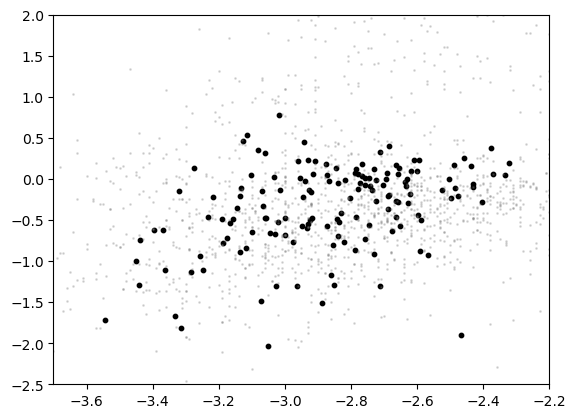

In [323]:
plt.scatter(uves.feh.values, uves.bafe.values, s=10, color='k')
plt.scatter(jina.feh.values, jina.bafe.values, color='grey', s=1, alpha=0.25)
plt.xlim(-3.7, -2.2)
plt.ylim(-2.5, 2.0)
plt.show()

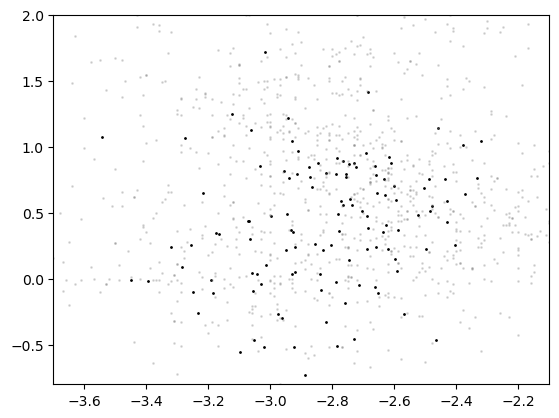

In [327]:
plt.scatter(uves.feh.values, uves.eufe.values, s=1, color='k')
plt.scatter(jina.feh.values, jina.eufe.values, color='grey', s=1, alpha=0.25)
plt.xlim(-3.7, -2.1)
plt.ylim(-0.8, 2.)
plt.show()

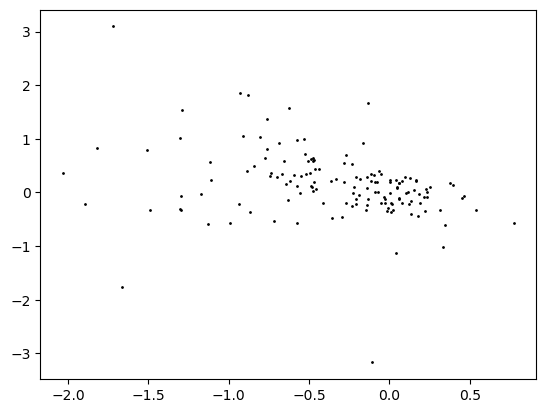

In [309]:
plt.scatter(uves.bafe.values, uves.srfe.values - uves.bafe.values, s=1, color='k')
# plt.ylim(-0.8, 2.)
plt.show()

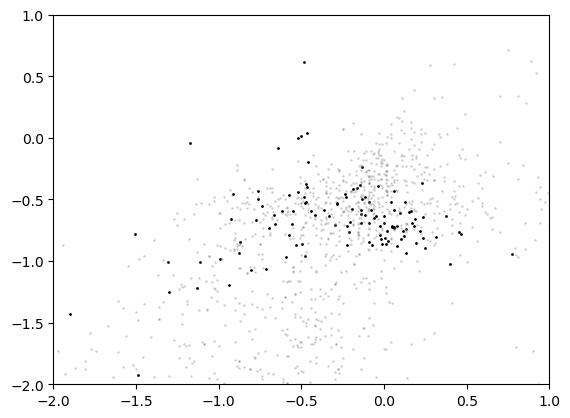

In [334]:
plt.scatter(uves.bafe.values, uves.bafe.values - uves.eufe.values, s=1, color='k')
plt.scatter(jina.bafe.values, jina.bafe.values - jina.eufe.values, color='grey', s=1, alpha=0.25)

plt.xlim(-2.0, 1.)
plt.ylim(-2.0, 1.)
plt.show()

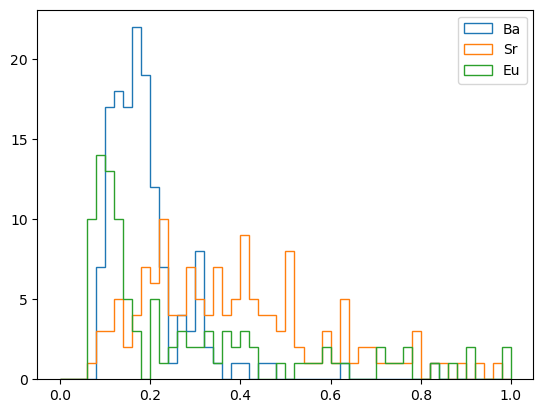

In [258]:
# plt.hist(uves_fe0.efe_sme.values, bins=25, histtype='step')
# plt.hist(uves_fe_sr.sr.values, bins=25, histtype='step')
# plt.hist(uves_fe_eu.eu.values, bins=25, histtype='step')

plt.hist(uves.eba_sme.values, bins=50, histtype='step', range=(0, 1.), label='Ba')
plt.hist(uves.esr_sme.values, bins=50, histtype='step', range=(0, 1.), label='Sr')
plt.hist(uves.eeu_sme.values, bins=50, histtype='step', range=(0, 1.), label='Eu')

# plt.hist(uves_fe_ba.ba.values - solar.abund.get_element('Ba'), bins=50, histtype='step', density=True)
# plt.hist(jina.bafe.values, bins=100, density=True)

# plt.xlim(-2,1)
plt.legend()
plt.show()

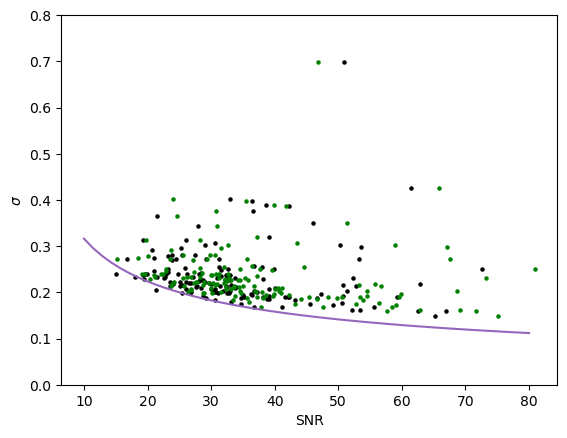

In [286]:
plt.scatter(uves.snr_4030.values, uves.efe_sme.values, s=5, color='k')
plt.scatter(uves.snr_4460.values, uves.efe_sme.values, s=5, color='g')

x = np.linspace(10, 80)
plt.plot(x, 1./x**0.5, color='C4')

plt.xlabel('SNR')
plt.ylabel(r'$\sigma$')
plt.ylim(0.0, 0.8)
plt.show()

In [24]:
#NLTE grids

# sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
# sme.nlte.set_nlte('Mg', 'nlte_Mg_ama51_pysme.grd')
# sme.nlte.set_nlte('Ba', 'nlte_Ba_ama51_pysme.grd')
# sme.nlte.set_nlte('Ca', 'nlte_Ca_ama51_pysme.grd')
# sme.nlte.set_nlte('H', 'nlte_H_ama51_pysme.grd')
# sme.nlte.set_nlte('C', 'nlte_C_ama51_pysme.grd')
# sme.nlte.set_nlte('N', 'nlte_N_ama51_pysme.grd')
# sme.nlte.set_nlte('Al', 'nlte_Al_ama51_pysme.grd')
# sme.nlte.set_nlte('Li', 'nlte_Li_ama51_pysme.grd')
# sme.nlte.set_nlte('Na', 'nlte_Na_ama51_pysme.grd')
# sme.nlte.set_nlte('Ti', 'marcs2012s_t2.0_Ti.grd')
# sme.nlte.set_nlte('K', 'nlte_K_ama51_pysme.grd')
# sme.nlte.set_nlte('Mn', 'nlte_Mn_ama51_pysme.grd')    
# sme.nlte.set_nlte('Si', 'nlte_Si_ama51_pysme.grd')
# sme.nlte.set_nlte('O', 'nlte_O_ama51_pysme.grd')